Sparsity Phi: 0.000 (PLSA) vs. 0.469 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.001 (ARTM)
Kernel contrast: 0.466 (PLSA) vs. 0.525 (ARTM)
Kernel purity: 0.215 (PLSA) vs. 0.359 (ARTM)
Perplexity: 2058.027 (PLSA) vs. 1950.717 (ARTM)


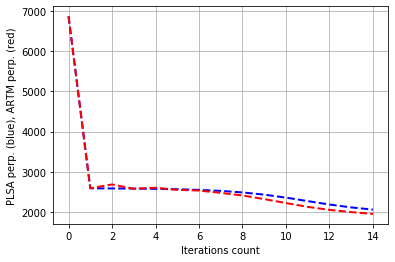

In [9]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import artm

batch_vectorizer = None
batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci',
                                            collection_name='kos', target_folder='kos')

    
dictionary = batch_vectorizer.dictionary
topic_names = ['topic_{}'.format(i) for i in range(15)]

model_plsa = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)])
model_plsa.initialize(dictionary=dictionary)

model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=-0.15)])
model_artm.initialize(dictionary=dictionary)

model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

def print_measures(model_plsa, model_artm):
    print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(model_plsa.num_phi_updates),
             model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(model_artm.num_phi_updates),
             model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()

print_measures(model_plsa, model_artm)